# Problem 3 PS 2
 Muhammad Bashir

In [25]:
# Load Libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [18]:
# set paths to working directory 
path = '/Users/muhammadbashir/GitHub/MuhammadCourses/Ec240a/Problem Sets/PS1'
# load RPS_calorie_data.out data and read only columns Y0tc and X0te.
calories = pd.read_csv(path + '/RPS_calorie_data.out',usecols=['Y0tc','X0te'])
calories.head()

,Y0tc,X0te
0,9.061790,9.917698
1,7.870896,8.276105
2,8.262976,8.036979
3,9.057076,9.212327
4,8.953918,9.826068


Let \( Y \) denote log calories and \( X \) denote log expenditure. Assume that
\[
m(x) = \mathbb{E}[Y \mid X = x] = \sum_{k=1}^{K} \alpha_k g_k(x),
\]

where \( g_k(x) = x^{k-1} \).

Using the power series basis described above and the Gram-Schmidt algorithm construct a new basis
that is orthogonal to the design points (set \( K = 12 \)). Let \( W_i \) denote the \( K \times 1 \) vector of orthonormal
basis functions for the \( i \)-th household. Compute the least squares fit
\( m (X_i) = W_i^0 \hat{\theta} \)
with
\[
\hat{\theta} =
\left( \sum_{i=1}^{N} W_i W_i^0 \right)^{-1}
\times
\left( \sum_{i=1}^{N} W_i Y_i \right).
\]
Plot this function onto a scatter of the unsmoothed data.


In [35]:
# First create K =12 g functions/polynomials, where g_k(x) = x^k-1 for the column X0te.
K = 12
for k in range(1,K+1):
    calories['X0te_g'+str(k)] = calories['X0te']**(k-1)

Orthogonalize g functions using Gram-Schmidt algoritm

In [36]:
calories.filter(like='X0te_g').head()

,X0te_g1,X0te_g2,X0te_g3,X0te_g4,X0te_g5,X0te_g6,X0te_g7,X0te_g8,X0te_g9,X0te_g10,X0te_g11,X0te_g12
0,1.0,9.917698,98.360734,975.512051,9674.833918,95952.081000,951623.761829,9.437917e+06,9.360241e+07,9.283204e+08,9.206802e+09,9.131028e+10
1,1.0,8.276105,68.493914,566.862824,4691.416251,38826.653493,321333.461103,2.659389e+06,2.200939e+07,1.821520e+08,1.507509e+09,1.247630e+10
2,1.0,8.036979,64.593031,519.132837,4172.259711,33532.363683,269498.902744,2.165957e+06,1.740775e+07,1.399057e+08,1.124419e+09,9.036935e+09
3,1.0,9.212327,84.866969,781.822268,7202.402386,66350.885962,611246.058223,5.630999e+06,5.187460e+07,4.778858e+08,4.402440e+09,4.055672e+10
4,1.0,9.826068,96.551612,948.722708,9322.213846,91600.707157,900074.777374,8.844196e+06,8.690367e+07,8.539214e+08,8.390690e+09,8.244749e+10


In [37]:
calories['X0te_f1'] = calories['X0te_g1']
calories['X0te_f2'] = calories['X0te_g2']-(calories['X0te_g2'] * calories['X0te_f1']).mean() / (calories['X0te_f1'] ** 2).mean() * calories['X0te_f1']
for k in range(3, K+1):
    fk = calories['X0te_g' + str(k)]
    for j in range(1, k-1):
        fj = calories['X0te_f' + str(j)]
        fk -= (calories['X0te_g' + str(k)] * fj).mean() / (fj ** 2).mean() * fj
    calories['X0te_f' + str(k)] = fk

Compute least square fit of this orthonormal basis

In [40]:
# Compute the OLS estimates of the coefficients of the K polynomials i.,e regress Y0tc on the K polynomials fk. 
# First create a list of the columns of the data frame that contain the K polynomials.
X = calories[['X0te_f'+str(k) for k in range(1,13)]]
X = np.array(X)
Y = calories['Y0tc']
Y = np.array(Y)

# Compute the OLS estimates of the coefficients of the K polynomials i.,e regress Y0tc on the K polynomials fk.
beta = np.linalg.inv(X.T @ X) @ X.T @ Y
# predict mean by multiplying the estimated coefficients by the polynomials.
calories['Y0tc_hat'] = X @ beta



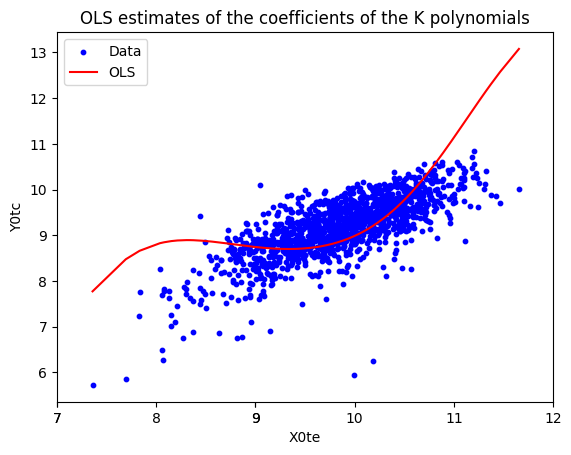

In [46]:

# Plot this function onto a scatter of the unsmoothed data.
plt.scatter(calories['X0te'], calories['Y0tc'], label='Data', color='blue', s=10)
sorted_indices = np.argsort(calories['X0te'])
plt.plot(calories['X0te'].iloc[sorted_indices], calories['Y0tc_hat'].iloc[sorted_indices], label='OLS', color='red')
plt.xlabel('X0te')
plt.ylabel('Y0tc')
plt.legend()
plt.title('OLS estimates of the coefficients of the K polynomials')

# Add 10 equally spaced xticks
xticks = np.linspace(np.floor(calories['X0te'].min()), np.ceil(calories['X0te'].max()), 8)
xticks = xticks.astype(int)
plt.xticks(xticks)

plt.show()

3. Now use the shrinkage estimator of Efromovich (1999) as described in lecture to estimate m (Xi). Plot
this function onto a scatter of the unsmoothed data. Comment on your findings.